In [1]:
import numpy as np
import os 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy import stats
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ranksums
from scipy.signal import find_peaks
from numba import jit, prange
import matplotlib as mpl
import random
import pickle
import gzip
from pathlib import Path
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2
import hdf5storage
from neo.io import AxonIO

/opt/anaconda3/envs/runyan_lab_alignment/lib/python3.11/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
from process_neural_data import *

deconv = deconvolution()
align = alignment()
processing = data_processing()

In [3]:
mouseID = 'IS-3-1R'
date = '2024-10-29'
server = 'Akhil Data'

# Deconvolution & delta F/F

In [3]:
F_file = 'Fall'

In [ ]:
variables_to_load = ['F', 'Fneu', 'iscell']  # specify your variable names here
dff, z_dff = deconv.pydff(mouseID,date,server, 225, F_file, variables_to_load, 'AB')

/Volumes/Akhil Data/Akhil/ProcessedData/IS-3-1R/2024-10-29/suite2p/plane0
loaded Fall


In [8]:
denoisesig, deconvsig, dff_interp, options = deconv.decovolve(dff)

In [10]:
save_directory = Path(f"/Volumes/{server}/Akhil/ProcessedData/{mouseID}/{date}/spikes")
os.chdir(save_directory)
print(save_directory)

/Volumes/Akhil Data/Akhil/ProcessedData/IS-3-1R/2024-10-30/spikes


In [11]:
# Save the matrix using h5py
with h5py.File('{}_dff.mat'.format(F_file), 'w') as f:
    f.create_dataset('dff', data=dff)

# Save the matrix using h5py
with h5py.File('{}_deconvsig.mat'.format(F_file), 'w') as f:
    f.create_dataset('deconvsig', data=deconvsig)

# Data Alignment

In [4]:
def create_info_dict(mouseID, date):
    """
    Creates info dictionary from mouseID and date.
    
    Args:
        mouseID (str): Mouse identifier (e.g., 'IS-3-1R')
        date (str): Date in format 'YYYY-MM-DD'
    """
    # Convert YYYY-MM-DD to YYMMDD for virmen path
    short_date = date[2:].replace('-', '')  # Takes '2024-10-29' -> '241029'
    
    info = {
        "mousename": mouseID,
        "mouse": mouseID,
        "date": date,
        "server": "/Volumes/Akhil Data",
        "experimenter_name": "Akhil",
        "sync_base_path": f"/Volumes/Akhil Data/Akhil/RawData/{mouseID}/wavesurfer/{date}/",
        "virmen_base": f"/Volumes/Akhil Data/Akhil/RawData/{mouseID}/virmen/AB{mouseID}_{short_date}",
        "imaging_base_path": f"/Volumes/Akhil Data/Akhil/RawData/{mouseID}/{date}/",
        "save_path": f"/Volumes/Akhil Data/Akhil/ProcessedData/{mouseID}/{date}/VR/",
        "processed_path": f"/Volumes/Akhil Data/Akhil/ProcessedData/{mouseID}/{date}/spikes/",
        "is_stim_dataset": 1,
        "galvo_channel": 7,
        "virmen_channel": 6,
        "vr_sync_string": "sync_"
    }
    return info

In [5]:
info = create_info_dict(mouseID, date)

# Sound info
sound_info = {
    "spkr_channel_number": [4, 8],
    "speaker_ids": [1, 2],
    "mult_spkr": 0
}

# Load conditions per speaker
runyan5 = "/Volumes/Runyan5"
conditions_path = os.path.join(runyan5, "Connie/condition_per_speaker.mat")
conditions_per_speaker = scipy.io.loadmat(conditions_path)['conditions_per_speaker']
sound_info["condition_per_speaker"] = conditions_per_speaker

# Task info
task_info = {
    "correct": 3,        # correct ITI time in sec
    "incorrect": 5,      # incorrect ITI time in sec
    "min": 1.5,          # minimum time in sec to complete a trial
    "channel_number": [info["galvo_channel"], info["virmen_channel"]] + sound_info["spkr_channel_number"]
}

# Load reward info from Runyan4 server
runyan4 = "/Volumes/Runyan4"
mdl_pure_sol_path = os.path.join(runyan4, "Connie/extra_tests/2023-12-11/mdl_pure_sol.mat")
mdl_end_trial_sol_path = os.path.join(runyan4, "Connie/extra_tests/2023-12-11/mdl_end_trial_sol.mat")

mdl_pure_sol = scipy.io.loadmat(mdl_pure_sol_path)
mdl_end_trial_sol = scipy.io.loadmat(mdl_end_trial_sol_path)

In [10]:
# Paths for dff and deconvolution files
fall_dff_path = os.path.join(info["processed_path"], "Fall_dff.mat")
fall_deconv_path = os.path.join(info["processed_path"], "Fall_deconvsig.mat")

# Load dff and deconvolution data
with h5py.File(fall_dff_path, 'r') as f:
    dff = f['/dff'][:]

with h5py.File(fall_deconv_path, 'r') as f:
    deconv = f['/deconvsig'][:]

In [6]:
dataCell, data = align.load_virmen_data(info)

Imaging Dir: TSeries-10252024-0809-000, Sync File: sync_behavior_0000.abf


/opt/anaconda3/envs/runyan_lab_alignment/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


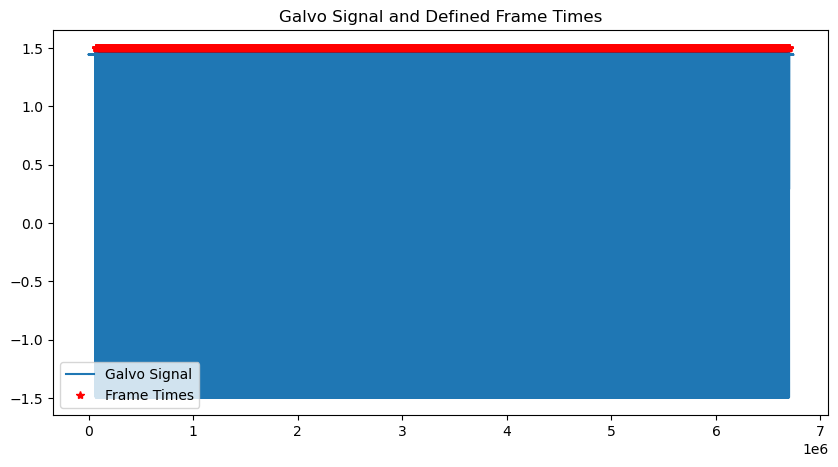

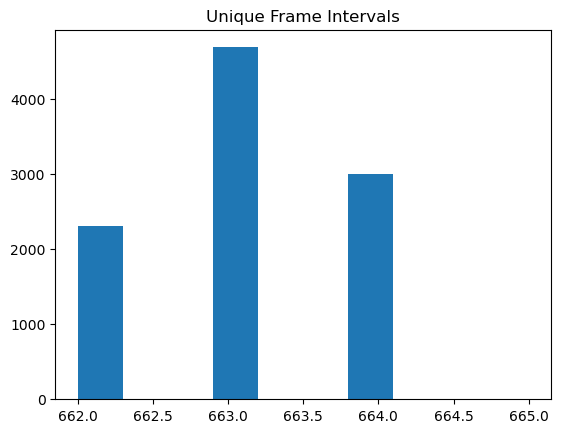

Imaging Dir: TSeries-10252024-0809-001, Sync File: sync_behavior_0001.abf


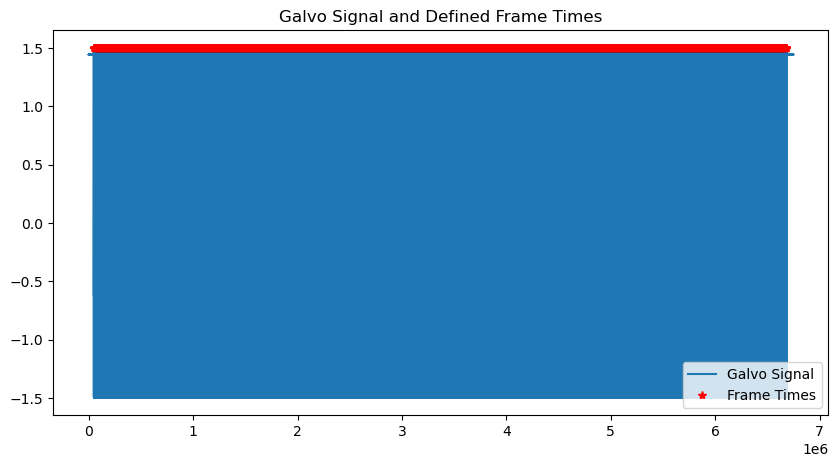

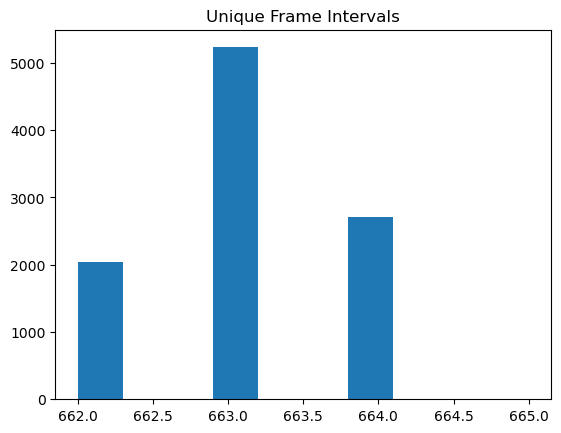

Imaging Dir: TSeries-10252024-0809-002, Sync File: sync_behavior_0002.abf


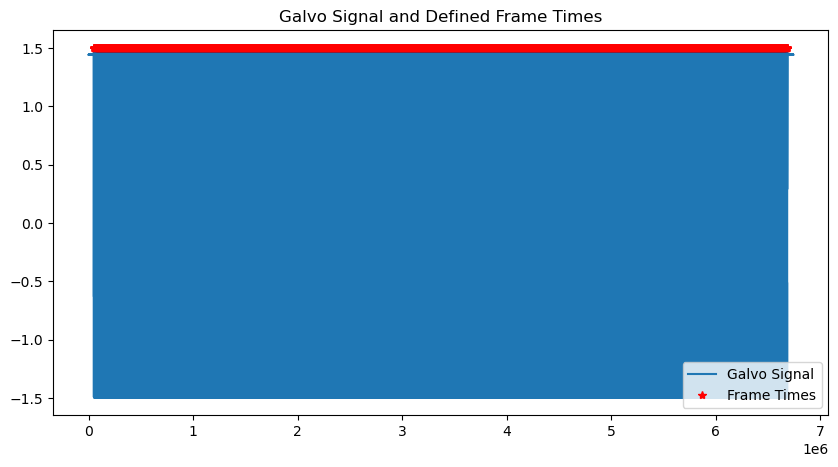

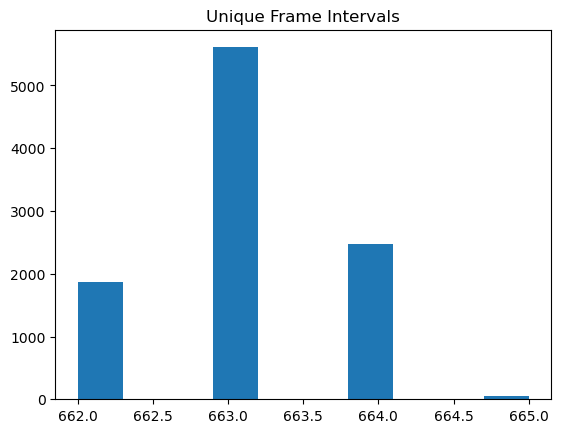

Imaging Dir: TSeries-10252024-0809-003, Sync File: sync_behavior_0003.abf


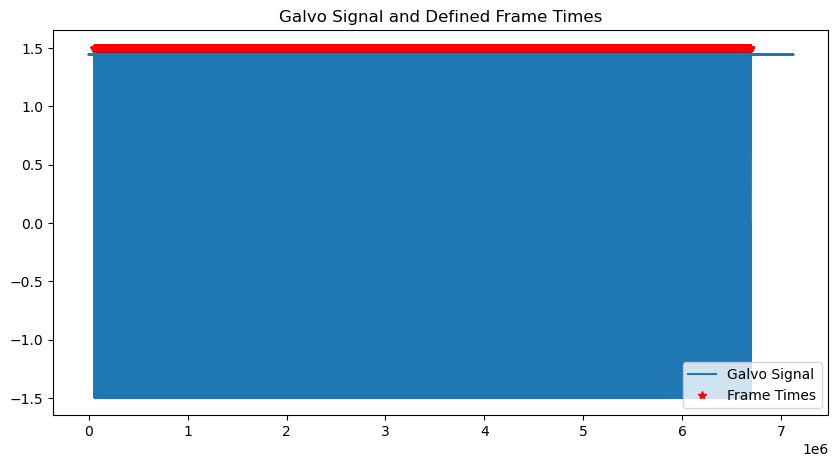

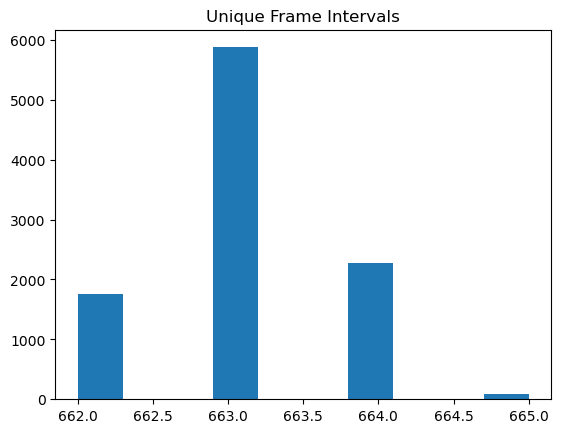

In [51]:
imaging_base_path = info["imaging_base_path"]
sync_base_path = info["sync_base_path"]
channel_number = 4
plot_on = 1

alignment_info = align.get_frame_times(info["imaging_base_path"], info["sync_base_path"], channel_number, plot_on)

In [8]:
string = info["vr_sync_string"]
virmen_channel = 1

digidata_its = align.get_digidata_iterations(sync_base_path, string, virmen_channel)

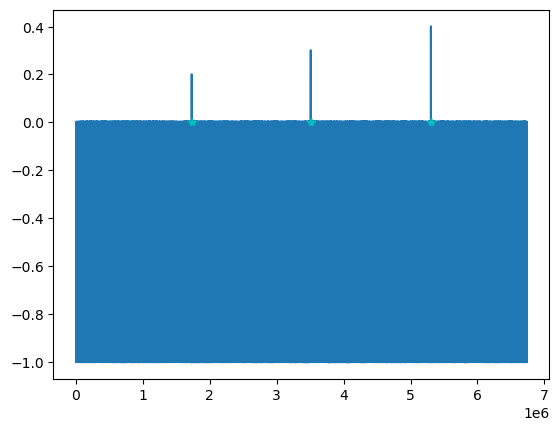

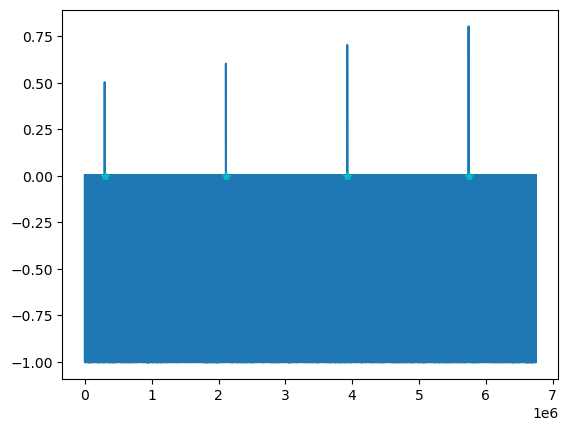

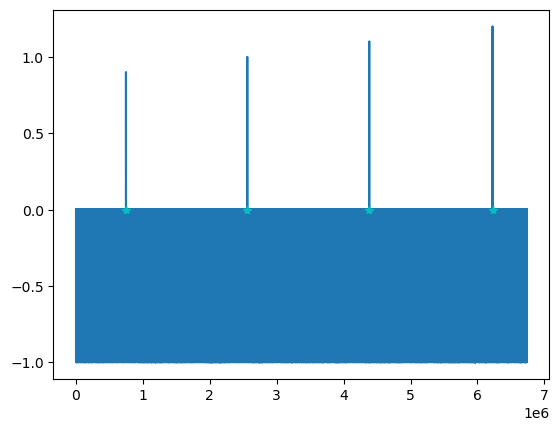

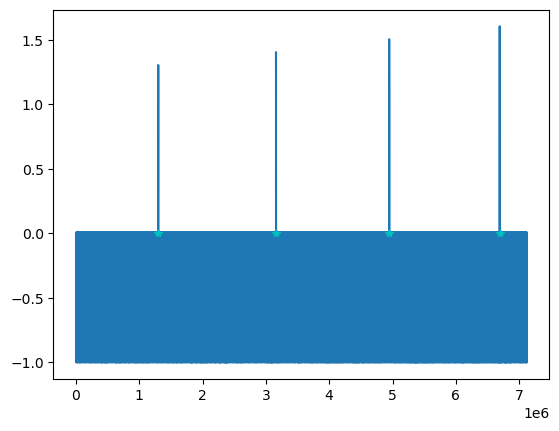

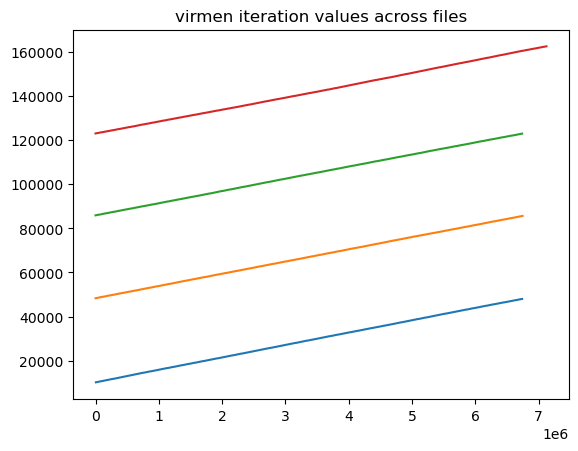

In [9]:
virmen_it, trial_its, sound_condition_array = align.get_virmen_iterations_and_times_digidata_positive_peaks(
    base=info["sync_base_path"],
    virmen_channel_number=info["virmen_channel"],
    string=info["vr_sync_string"],
    sound_condition_array=[],
    data=data,
    file_trial_ids=[],
    file_estimated_trial_info=[]  # Added this parameter
)

In [33]:
imaging = align.align_virmen_data(dff, deconv, virmen_it, alignment_info, data, dataCell, trial_its, stimulus_info=None, reward_info=None)

In [12]:
path = '/Volumes/Akhil Data/Akhil/ProcessedData/{}/{}/'.format(mouseID, date)
os.chdir(path)
hdf5storage.savemat('imaging_py.mat', {'imaging': imaging}, format='7.3', oned_as='column')

In [34]:
imaging.keys()

dict_keys(['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5', 'trial_6', 'trial_7', 'trial_8', 'trial_9', 'trial_10', 'trial_11', 'trial_12', 'trial_13', 'trial_14', 'trial_15', 'trial_16', 'trial_17', 'trial_18', 'trial_19', 'trial_20', 'trial_21', 'trial_22', 'trial_23', 'trial_24', 'trial_25', 'trial_26', 'trial_27', 'trial_28', 'trial_29', 'trial_30', 'trial_31', 'trial_32', 'trial_33', 'trial_34', 'trial_35', 'trial_36', 'trial_37', 'trial_38', 'trial_39', 'trial_40', 'trial_41', 'trial_42', 'trial_43', 'trial_44', 'trial_45', 'trial_46', 'trial_47', 'trial_48', 'trial_49', 'trial_50', 'trial_51', 'trial_52', 'trial_53', 'trial_54', 'trial_55', 'trial_56', 'trial_57', 'trial_58', 'trial_59', 'trial_60', 'trial_61', 'trial_62', 'trial_63', 'trial_64', 'trial_65', 'trial_66', 'trial_67', 'trial_68', 'trial_69', 'trial_70', 'trial_71', 'trial_72', 'trial_73', 'trial_74', 'trial_75', 'trial_76', 'trial_77', 'trial_78', 'trial_79', 'trial_80', 'trial_81', 'trial_82', 'trial_83', 't

In [38]:
imaging['trial_145'].keys()

dict_keys(['start_it', 'end_it', 'iti_start_it', 'iti_end_it', 'virmen_trial_info', 'movement_in_virmen_time', 'frame_id', 'dff', 'z_dff', 'deconv', 'relative_frames', 'file_num', 'movement_in_imaging_time', 'good_trial'])

In [39]:
imaging['trial_145']

{'start_it': 95383,
 'end_it': 95787,
 'iti_start_it': 95788,
 'iti_end_it': 95965,
 'virmen_trial_info': {'correct': 1,
  'left_turn': 1,
  'condition': 1,
  'is_stim_trial': None},
 'movement_in_virmen_time': {'y_position': array([  0.        ,   0.        ,   6.5106616 ,   7.31420279,
           9.41825294,  11.73454094,  14.2379427 ,  16.62693596,
          19.10091782,  21.5278492 ,  23.88281822,  26.29151917,
          28.45130157,  30.64199448,  32.87182236,  35.12122345,
          37.29557037,  39.57056427,  41.62601471,  43.59771729,
          45.65189743,  47.59117508,  49.56716919,  51.5151329 ,
          53.35783768,  61.23777771,  62.57376099,  64.28747559,
          65.95119476,  67.6661911 ,  69.18209076,  70.69812775,
          72.13635254,  73.53752136,  74.9865799 ,  76.43684387,
          77.85141754,  79.30119324,  80.77880096,  82.13406372,
          83.55826569,  84.97110748,  86.14673615,  87.35063934,
          88.57386017,  89.65255737,  90.77012634,  91.848609

In [45]:
imaging['trial_145']['frame_id']

array([2544, 2544, 2544, 2545, 2545, 2545, 2545, 2546, 2546, 2546, 2547,
       2547, 2547, 2548, 2548, 2548, 2548, 2549, 2549, 2549, 2549, 2550,
       2550, 2550, 2550, 2551, 2551, 2551, 2551, 2552, 2552, 2552, 2552,
       2553, 2554, 2554, 2554, 2554, 2555, 2555, 2555, 2555, 2556, 2556,
       2556, 2556, 2557, 2557, 2557, 2557, 2558, 2558, 2558, 2558, 2559,
       2559, 2559, 2559, 2560, 2560, 2560, 2560, 2561, 2561, 2561, 2561,
       2562, 2562, 2562, 2562, 2563, 2563, 2563, 2563, 2564, 2564, 2564,
       2564, 2565, 2565, 2565, 2565, 2565, 2566, 2566, 2566, 2566, 2567,
       2567, 2567, 2567, 2568, 2568, 2568, 2568, 2569, 2569, 2569, 2569,
       2570, 2570, 2570, 2570, 2571, 2571, 2571, 2571, 2572, 2572, 2572,
       2572, 2573, 2573, 2573, 2573, 2574, 2574, 2574, 2574, 2575, 2575,
       2575, 2575, 2576, 2576, 2576, 2576, 2577, 2577, 2577, 2577, 2578,
       2578, 2578, 2578, 2579, 2579, 2579, 2579, 2580, 2580, 2580, 2580,
       2581, 2581, 2581, 2581, 2582, 2582, 2582, 25

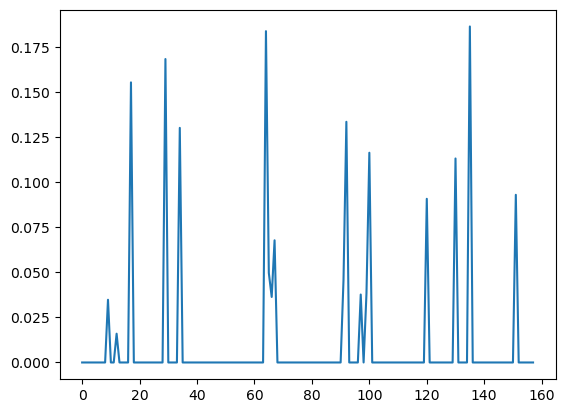

In [50]:
plt.plot(imaging['trial_145']['deconv'][0,1:])

# Data Processing (post alignment)

In [13]:
mouseID = 'IS-3-1R'
date = '2024-10-29'
path = '/Volumes/Akhil Data/Akhil/ProcessedData/{}/{}/'.format(mouseID, date)
data_dict, imaged_trials = processing.convert_imaging_mat_to_dict(path, imaging)

In [15]:
data_dict[10].keys()

dict_keys(['y_position', 'x_position', 'is_reward', 'in_ITI', 'pure_tones', 'maze_frames', 'iti_frames', 'reward_frames', 'turn_frame', 'correct', 'left_turn', 'condition', 'deconv_data', 'dff_data', 'z_dff_data'])

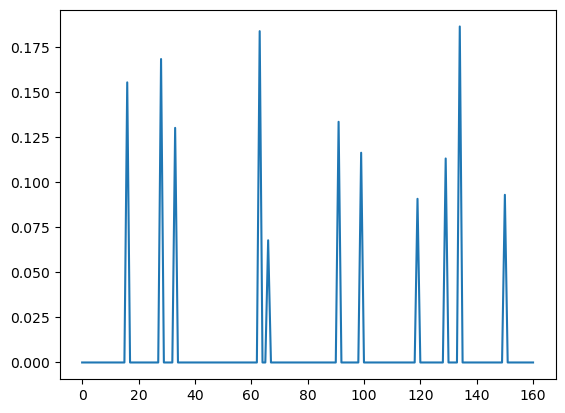

In [41]:
plt.plot(data_dict[145]['deconv_data'][:,0])

In [19]:
neural_data = processing.neural_data_extraction(data_dict)

In [20]:
task_df = processing.organize_behavioral_data_into_df(data_dict, tasktype='aud')

# Adding a column for the choice on the previous trial
task_df['prev_choice'] = task_df['choice'].shift(1)

# Setting the first trial's previous choice to NaN explicitly (although shift already does this)
task_df.iloc[0, task_df.columns.get_loc('prev_choice')] = 0

task_df_pruned = task_df[task_df['trial length'] > 125]
neural_data_pruned = [neural_data[i] for i in task_df_pruned.index.tolist()]
task_df_pruned = task_df_pruned.reset_index()

In [21]:
task_df_pruned

,index,Trial,trial_type,choice,outcome,Visual_Stim,Audio_Stim,context,sound onset,turn frame,iti start,trial length,prev_choice
0,0,9,1,1,0,NaN,0,2,32,174,191,266,0.0
1,1,10,1,1,0,NaN,0,2,73,183,226,301,1.0
2,2,11,1,0,1,NaN,0,2,26,332,347,392,1.0
3,3,12,1,0,1,NaN,0,2,27,112,129,174,0.0
4,4,13,2,0,0,NaN,1,2,18,80,95,170,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,234,251,1,0,1,NaN,0,2,12,84,99,144,0.0
186,235,252,2,0,0,NaN,1,2,9,56,71,146,0.0
187,236,253,2,0,0,NaN,1,2,87,292,310,385,0.0
188,237,254,2,0,0,NaN,1,2,9,235,252,327,0.0


In [22]:
stimulus_activity_all_trials = []
choice_activity_all_trials = []
iti_activity_all_trials = []
task_windows_list = []
for trial in list(range(len(neural_data_pruned))):
     sound_onset = task_df_pruned['sound onset'][trial]
     three_sec_after = sound_onset+30
     stimulus_period_activity = neural_data_pruned[trial][:,sound_onset:three_sec_after]

     iti_start = task_df_pruned['iti start'][trial]
     two_seconds_before_iti = iti_start-15

     choice_period_activity = neural_data_pruned[trial][:,two_seconds_before_iti:iti_start]
     iti_period_activity = neural_data_pruned[trial][:,iti_start+1:iti_start+45]

     stimulus_activity_all_trials.append(stimulus_period_activity)
     choice_activity_all_trials.append(choice_period_activity)
     iti_activity_all_trials.append(iti_period_activity)
     task_windows = [(sound_onset,three_sec_after), (two_seconds_before_iti,iti_start),(iti_start+1,iti_start+45)]
     task_windows_list.append(task_windows)
stimulus_activity_all_trials = np.array(stimulus_activity_all_trials)
choice_activity_all_trials = np.array(choice_activity_all_trials)
iti_activity_all_trials = np.array(iti_activity_all_trials)

In [23]:
aligned_data_dict = {
    'stimulus_activity':stimulus_activity_all_trials, 
    'choice_activity': choice_activity_all_trials, 
    'iti_activity': iti_activity_all_trials
}